# In this script, I Experiment with the Cifar-10 dataset. Moreover, I will transfer the AANN modifications to conv-deconv autoencoder architecture.
-------------------------------------------------------------------------------------------------------------------
### Technology used: Tensorflow-core 

In [1]:
# packages used for machine learning
import tensorflow as tf

# packages used for processing: 
from six.moves import cPickle as pickle # for reading the data
import matplotlib.pyplot as plt # for visualization
import numpy as np
from sklearn.preprocessing import OneHotEncoder # for encoding the labels in one hot form

# for operating system related stuff
import os
import sys # for memory usage of objects
from subprocess import check_output

# to plot the images inline
%matplotlib inline

In [2]:
# Input data files are available in the "../Data/" directory.

def exec_command(cmd):
    '''
        function to execute a shell command and see it's 
        output in the python console
        @params
        cmd = the command to be executed along with the arguments
              ex: ['ls', '../input']
    '''
    print(check_output(cmd).decode("utf8"))

In [3]:
# check the structure of the project directory
exec_command(['ls', '../..'])

Data
LICENSE
Literature_survey
Models
README.md
Res
Scripts



In [4]:
''' Set the constants for the script '''

# various paths of the files
data_path = "../../Data/cifar-10" # the data path
train_meta = os.path.join(data_path, "batches.meta")
idea = "IDEA_1"
base_model_path = '../../Models'
idea_model_path = os.path.join(base_model_path, idea)

# constant values:
size = 32 # the images of size 32 x 32
channels = 3 # RGB channels
highest_pixel_value = 255.0 # 8 bits for every channel. So, max value is 255
no_of_epochs = 100 # No. of epochs to run
no_of_batches = 5 # There are 5 batches in the dataset
checkpoint_factor = 5 # save the model after every 5 steps (epochs)
num_classes = 10 # There are 10 different classes in the dataset
k_size = 5 # all kernels are 5x5
n_hidden_neurons_in_fc_layers = 512
representation_vector_length = 128 # length of the mid_level representation vector
batch_size = 128 # we look at 5000 images at a time

In [5]:
# check the contents inside the data folder
exec_command(['ls', data_path])

batches.meta
data_batch_1
data_batch_2
data_batch_3
data_batch_4
data_batch_5
readme.html
test_batch



In [6]:
# function to unPickle a file: 
def unpickle(file):
    '''
        This function takes the file path and unPickles the file acquired from it
        @Param file: the string path of the file
        @return: The dict object unPickled from the file
    '''
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

### Let's check the contents of the batches.meta file

In [7]:
meta_data = unpickle(train_meta)

# check it's contents
meta_data

{'label_names': ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 'num_cases_per_batch': 10000,
 'num_vis': 3072}

### Let's read and display some of the images from the dataset along with their labels

In [8]:
train_batch_preliminary = unpickle(os.path.join(data_path, "data_batch_3"))

# check it's contents
train_batch_preliminary.keys()

['data', 'labels', 'batch_label', 'filenames']

In [9]:
# Extract the first 3 images from the dataset
preliminary_data = train_batch_preliminary['data'].reshape((len(train_batch_preliminary['data']), 32, 32, 3), 
                                                           order='F')
preliminary_labels = train_batch_preliminary['labels']

# view some of the data:
preliminary_data[33, :10, :10, 2] #(10 x 10) data of blue channel of 33rd image

array([[178, 191, 193, 197, 202, 206, 207, 209, 214, 219],
       [140, 151, 155, 160, 166, 172, 173, 171, 176, 180],
       [ 84,  94, 119, 151, 146, 127, 125, 135, 139, 139],
       [ 16,  18,  85, 200, 207, 133,  71,  59,  72,  79],
       [  9,   3,  51, 183, 238, 219, 177,  94,  30,  16],
       [ 31,  25,  38, 148, 240, 249, 255, 235, 139,  39],
       [ 69,  65,  62, 115, 215, 250, 248, 253, 245, 201],
       [ 92,  89,  81,  89, 173, 240, 249, 253, 253, 255],
       [ 93,  90,  84,  85, 139, 217, 241, 246, 251, 252],
       [ 75,  74,  71,  87, 154, 208, 229, 239, 245, 250]], dtype=uint8)

In [10]:
# check a few values of the labels of the dataset
preliminary_labels[:10] 

[8, 5, 0, 6, 9, 2, 8, 3, 6, 2]

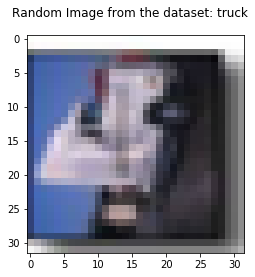

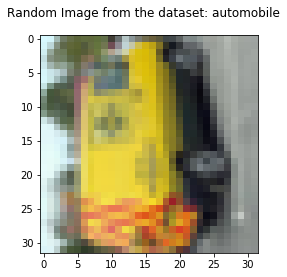

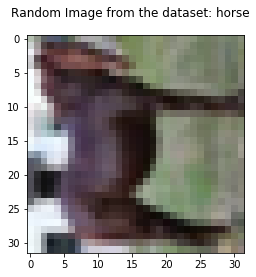

In [11]:
for _ in range(3):
    random_index = np.random.randint(preliminary_data.shape[0])
    
    plt.figure().suptitle("Random Image from the dataset: %s" %(meta_data['label_names'][preliminary_labels[random_index]]))
    plt.imshow(preliminary_data[random_index], interpolation='none')

### The images look blurred out because they are very low resolution images (32 x 32) pixels only.

## It can be seen that the images in the original dataset are skewed. So, we will have to rotate them by 90 degrees clockwise

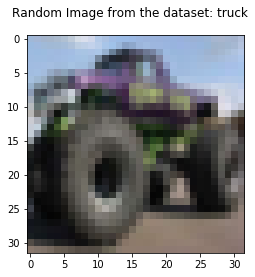

In [12]:
# let's try using the numpy.rot90 method for this:
random_index = np.random.randint(preliminary_data.shape[0])
    
plt.figure().suptitle("Random Image from the dataset: %s" %(meta_data['label_names'][preliminary_labels[random_index]]))
plt.imshow(np.rot90(preliminary_data[random_index], axes=(1, 0)), interpolation='none'); # suppress the unnecessary
# output

This works. So, now we can create a function to put all this together. This function would take the batch pickle file and create the data suitable for feeding it off to a convolutional neural network.

In [13]:
# The batch generator function:
def generateBatch(batchFile):
    '''
        The function to generate a batch of data suitable for performing the convNet operations on it
        @param batchFile -> the path of the input batchfile
        @return batch: (data, labels) -> the processed data.
    '''
    # unpickle the batch file:
    data_dict = unpickle(batchFile)
    
    # extract the data and labels from this dictionary
    unprocessed_data = data_dict['data']
    integer_labels = np.array(data_dict['labels']) # labels in integer form
    
    # reshape and rotate the data
    data = unprocessed_data.reshape((len(unprocessed_data), size, size, channels), order='F')
    processed_data = np.array(map(lambda x: np.rot90(x, axes=(1, 0)), data))
    
    # normalize the images by dividing all the pixels by 255
    processed_data = processed_data.astype(np.float32) / highest_pixel_value
    
    # encode the labels in one-hot encoded form
    # we use the sklearn.preprocessing package for doing this
    encoder = OneHotEncoder(sparse=False)
    encoded_labels = np.array(encoder.fit_transform(integer_labels.reshape(len(integer_labels), 1)))
    
    # return the processed data and the encoded_labels:
    return (processed_data, encoded_labels)

### Time to test this function

In [14]:
# load the batch no. 1 and check if it works correctly.
batch_data, batch_labels = generateBatch(os.path.join(data_path, "data_batch_1"))
print (batch_data.shape, batch_labels.shape)

# batch_data[0, :12, :12, 2]

((10000, 32, 32, 3), (10000, 10))


Random image shape: (32, 32, 3)
Random image dataTypefloat32


check if the data has been properly normalized
[[ 0.22745098  0.25490198  0.25098041]
 [ 0.22745098  0.21568628  0.22745098]
 [ 0.27058825  0.25490198  0.27058825]]


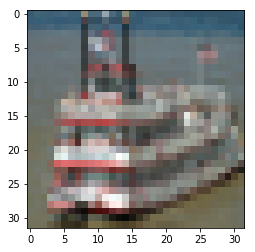

In [15]:
# extract one image from the data and display it
randomIndex = np.random.randint(batch_data.shape[0])
randomImage = batch_data[randomIndex]
print "Random image shape: " + str(randomImage.shape)

print "Random image dataType" + str(randomImage.dtype)

print "\n\ncheck if the data has been properly normalized"
print randomImage[:3, :3, 0]

# Visualize the random image from the dataset
plt.figure()
plt.imshow(randomImage, interpolation='none'); # suppress the unnecessary

Alright! So, the data extraction module is setup. Let's move on to the actual model building and training.

# Define the computation graph. This uses a conv-deconv network for the ANN concept

### define the placeholders for the computations:

In [16]:
# point to reset the graph:
tf.reset_default_graph()

In [17]:
with tf.variable_scope("Placeholders"):
    tf_input = tf.placeholder(tf.float32, shape=(None, size, size, channels), name="inputs")
    
    # add an image summary for the tf_input
    tf_input_summary = tf.summary.image("Input_images", tf_input)
    
    tf_labels = tf.placeholder(tf.float32, shape=(None, num_classes), name="labels")
    # this is to send in the representation vector tweaked by us to generate images that we want
    tf_representation_vector = tf.placeholder(tf.float32, shape=(None, num_classes), name="representation") 

In [18]:
# print all these tensors to check if they have been correctly defined
tf_input, tf_labels, tf_representation_vector
# all look good

(<tf.Tensor 'Placeholders/inputs:0' shape=(?, 32, 32, 3) dtype=float32>,
 <tf.Tensor 'Placeholders/labels:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'Placeholders/representation:0' shape=(?, 10) dtype=float32>)

### define the kernel and bias variables used for the computation. I am defining them separately instead of using the layers api from the latest tensorflow because I am going to use the same weights while deconvolving the representations (Use of tied weights).

In [19]:
with tf.variable_scope("Weights_and_biases"):
    # special b0 for the input images to be added when performing the backward computations
    b0 = tf.get_variable("b0", shape=(1, size, size, channels), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    # normal kernel weights and biases
    w1 = tf.get_variable("W1", shape=(k_size, k_size, channels, 4), dtype=tf.float32, 
                         initializer=tf.truncated_normal_initializer())
    
    b1 = tf.get_variable("b1", shape=(1, 16, 16, 4), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    w2 = tf.get_variable("W2", shape=(k_size, k_size, 4, 8), dtype=tf.float32, 
                         initializer=tf.truncated_normal_initializer())
    
    b2 = tf.get_variable("b2", shape=(1, 8, 8, 8), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    w3 = tf.get_variable("W3", shape=(k_size, k_size, 8, 16), dtype=tf.float32, 
                         initializer=tf.truncated_normal_initializer())
    
    b3 = tf.get_variable("b3", shape=(1, 4, 4, 16), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    w4 = tf.get_variable("W4", shape=(k_size, k_size, 16, 32), dtype=tf.float32, 
                         initializer=tf.truncated_normal_initializer())
    
    b4 = tf.get_variable("b4", shape=(1, 2, 2, 32), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    # two more weights and biases for the final fully connected layers
    
    w_fc1 = tf.get_variable("W_fc1", shape=(representation_vector_length, n_hidden_neurons_in_fc_layers), 
                            dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
    
    b_fc1 = tf.get_variable("b_fc1", shape=(1, n_hidden_neurons_in_fc_layers), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    w_fc2 = tf.get_variable("W_fc2", shape=(n_hidden_neurons_in_fc_layers, num_classes), dtype=tf.float32, 
                         initializer=tf.contrib.layers.xavier_initializer())
    
    b_fc2 = tf.get_variable("b_fc2", shape=(1, num_classes), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    

### define the forward computations

In [20]:
# define a function for the forward_computations (named as encode)
def encode(inp):
    '''
        ** Note this function uses globally defined filter and bias weights
        ** activation function used is tf.abs! (AANN idea)
        Function to encode the given input images into the final num_classes-dimensional representation vector
        @param
        inp => tensor corresponding to batch of input images
        @return => tensor of shape [batch_size x num_classes] 
    '''
    stride_pattern = [1, 2, 2, 1] # define the stride pattern to halve the image everytime
    padding_pattern = "SAME" # padding pattern for the conv layers
    
    # define the convolution layers:
    z1 = tf.nn.conv2d(inp, w1, stride_pattern, padding_pattern) + b1
    a1 = tf.abs(z1)
    
    z2 = tf.nn.conv2d(a1, w2, stride_pattern, padding_pattern) + b2
    a2 = tf.abs(z2)
    
    z3 = tf.nn.conv2d(a2, w3, stride_pattern, padding_pattern) + b3
    a3 = tf.abs(z3)
    
    z4 = tf.nn.conv2d(a3, w4, stride_pattern, padding_pattern) + b4
    a4 = tf.abs(z4)
    
    # reshape the a4 activation map:
    fc_inp = tf.reshape(a4, shape=(-1, representation_vector_length))
    
    assert fc_inp.shape[-1] == representation_vector_length, "mid_level_representation_vector isn't 128 dimensional"
    
    # define the fully connected layers:
    
    z_fc1 = tf.matmul(fc_inp, w_fc1) + b_fc1
    a_fc1 = tf.abs(z_fc1)
    
    z_fc2 = tf.matmul(a_fc1, w_fc2) + b_fc2
    a_fc2 = tf.abs(z_fc2)
    
    assert a_fc2.shape[-1] == num_classes, "final_representation_vector isn't 10 dimensional"
    
    # if everything is fine, return the final activation vectors:
    return a_fc2, tf.shape(a1), tf.shape(a2), tf.shape(a3)

In [21]:
with tf.variable_scope("Encoder"):
    y_, sha1, sha2, sha3 = encode(tf_input)

In [22]:
# check the type of y_ 
print y_
# looks good alright!

Tensor("Encoder/Abs_5:0", shape=(?, 10), dtype=float32)


### define the backward computations

In [23]:
def decode(inp, sha1, sha2, sha3):
    ''' 
        ** Note this function uses globally defined filter and bias weights
        ** activation function used is tf.abs! (AANN idea)
        Function to decode the given input representation vector into 
        the size - dimensional images that should be as close as possible
        @param
        inp => tensor corresponding to batch of representation vectors
        @return => tensor of shape [batch_size x size x size x channels]
    '''
    stride_pattern = [1, 2, 2, 1] # define the stride pattern to halve the image everytime
    padding_pattern = "SAME" # padding pattern for the conv layers
    
    # define the backward pass through the fully connected layers:
    z_b_1 = tf.matmul(inp, tf.transpose(w_fc2)) + b_fc1
    a_b_1 = tf.abs(z_b_1)
    
    z_b_2 = tf.matmul(a_b_1, tf.transpose(w_fc1)) + tf.reshape(b4, shape=(1, -1))
    a_b_2 = tf.abs(z_b_2)
    
    assert a_b_2.shape[-1] == representation_vector_length, "reverse_pass: vector not 128 dimensional"
    
    # reshape the vector into a feature map:
    dconv_in = tf.reshape(a_b_2, shape=(-1, 2, 2, 32)) # reshape into 2x2 maps
    
    # define the deconvolution operations
    z_b_dconv_1 = tf.nn.conv2d_transpose(dconv_in, w4, sha3, 
                                         stride_pattern, padding_pattern) + b3
    a_b_dconv_1 = tf.abs(z_b_dconv_1)

    
    z_b_dconv_2 = tf.nn.conv2d_transpose(a_b_dconv_1, w3, sha2,
                                        stride_pattern, padding_pattern) + b2
    a_b_dconv_2 = tf.abs(z_b_dconv_2)    
    
    
    z_b_dconv_3 = tf.nn.conv2d_transpose(a_b_dconv_2, w2, sha1,
                                        stride_pattern, padding_pattern) + b1
    a_b_dconv_3 = tf.abs(z_b_dconv_3)
    
    
    z_b_dconv_4 = tf.nn.conv2d_transpose(a_b_dconv_3, w1, tf.shape(tf_input),
                                        stride_pattern, padding_pattern) + b0
    a_b_dconv_4 = tf.abs(z_b_dconv_4)
    
    # return the final computed image:
    return a_b_dconv_4

In [24]:
with tf.variable_scope("Decoder"):
    x_ = decode(y_, sha1, sha2, sha3)
    
    # add the image summary for the x_ tensor
    x__summary = tf.summary.image("Network_generated_image", x_)

In [25]:
# check if the x_ is a good tensor
print x_
# looks good

Tensor("Decoder/Abs_5:0", shape=(?, 32, 32, 3), dtype=float32)


In [26]:
# define the decoder predictions:
with tf.variable_scope("Decoder_predictions"):
    generated_image = decode(tf_representation_vector, sha1, sha2, sha3)

In [27]:
# check sanity of the generated_image
print generated_image
# looks good! :)

Tensor("Decoder_predictions/Abs_5:0", shape=(?, 32, 32, 3), dtype=float32)


In [28]:
# define the predictions generated by the network in the forward direction:
def direction_cosines(vector):
    '''
        function to calculate the direction cosines of the given batch of input vectors
        @param
        vector => activations tensor 
        @return => the direction cosines of x
    '''
    sqr = tf.square(vector)
    div_val = tf.sqrt(tf.reduce_sum(sqr, axis=1, keep_dims=True))
    
    # return the direction cosines of the vector:
    return vector / div_val

# use this function to define the predictions:
with tf.variable_scope("Predictions"):
    predictions = direction_cosines(y_)

In [29]:
predictions

<tf.Tensor 'Predictions/div:0' shape=(?, 10) dtype=float32>

## Time to define the costs:
### Forward cost:

In [30]:
with tf.variable_scope("Forward_cost"):
    fwd_cost = tf.reduce_mean(tf.abs(predictions - tf_labels))
    
    # add scalar summary for the fwd_cost
    fwd_cost_summary = tf.summary.scalar("Forward_cost", fwd_cost)

### Backward cost:

In [31]:
with tf.variable_scope("Backward_cost"):
    bwd_cost = tf.reduce_mean(tf.abs(x_ - tf_input))
    
    # add a scalar summary for the bwd_cost
    bwd_cost_summary = tf.summary.scalar("Backward_cost", bwd_cost)

## Define the final cost and the training step:

In [32]:
with tf.variable_scope("Final_cost"):
    cost = fwd_cost + bwd_cost
    
    # add a scalar summary
    cost_summary = tf.summary.scalar("Final_cost", cost)

In [33]:
with tf.variable_scope("Trainer"):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_step = optimizer.minimize(cost) # minimize the final cost

## Perform the init and summary errands:

In [34]:
with tf.variable_scope("Errands"):
    init = tf.global_variables_initializer()
    all_summaries = tf.summary.merge_all()

# Create a tensorboard writer and visualize this graph before starting the training loop

In [35]:
model_path = os.path.join(idea_model_path, "Model_cifar_3")

## Now, let's write the session code to run this computation graph and perform the training

In [36]:
''' 
    WARNING WARNING WARNING!!! This is the main training cell. Since, the data used for this task is CIFAR-10, 
    This cell will take a really really long time on low-end machines. It will however not crash your pc, since 
    I have bootstrapped the training in such a way that it loads a small chunk of data at a time to train.
    
    It took me around 5hrs to execute this cell entirely.
'''

with tf.Session() as sess:
    
    tensorboard_writer = tf.summary.FileWriter(logdir=model_path, graph=sess.graph)
    saver = tf.train.Saver(max_to_keep=2)
    
    if(os.path.isfile(os.path.join(model_path, "checkpoint"))):
        # load the weights from the model1
        # instead of global variable initializer, restore the graph:
        saver.restore(sess, tf.train.latest_checkpoint(model_path))
    
    else:
        # initialize all the variables
        sess.run(tf.global_variables_initializer())
    
    g_step = 76321
    for ep in range(194, 300):  # epochs loop
        
        print "epoch: " + str(ep + 1)
        print "================================================================================================="
        print "================================================================================================="
        
        for batch_n in range(no_of_batches):  # batches loop
            # generate the batch images and labels
            batch_images, batch_labels = generateBatch(os.path.join(data_path, "data_batch_" + str(batch_n + 1)))
            
            min_batch_size = batch_size 
            
            print "current_batch: " + str(batch_n + 1)
            
            for index in range(int(np.ceil(float(len(batch_images)) / min_batch_size))):
                start = index * min_batch_size
                end = start + min_batch_size
                minX = batch_images[start: end]; minY = batch_labels[start: end]
                
                _, loss = sess.run([train_step, cost], feed_dict={tf_input: minX, tf_labels: minY})
                
                if(index % 35 ==0):
                    print('range:{} loss= {}'.format((start, end), loss))
            
                g_step += 1
                
            print "\n=========================================================================================\n"
        
        if((ep + 1) % checkpoint_factor == 0 or ep == 0):
            
            # calculate the summaries:
            sums = sess.run(all_summaries, feed_dict={tf_input: minX, tf_labels: minY})
            
            # add the summaries to the fileWriter
            tensorboard_writer.add_summary(sums, global_step = g_step)
            
            # save the model trained so far:
            saver.save(sess, os.path.join(model_path, "model_cifar_3"), global_step = (ep + 1))
        
    print "================================================================================================="
    print "================================================================================================="

INFO:tensorflow:Restoring parameters from ../../Models/IDEA_1/Model_cifar_3/model_cifar_3-190
epoch: 195
current_batch: 1
range:(0, 128) loss= 0.343792796135
range:(4480, 4608) loss= 0.355322062969
range:(8960, 9088) loss= 0.359214276075


current_batch: 2
range:(0, 128) loss= 0.362949430943
range:(4480, 4608) loss= 0.363498151302
range:(8960, 9088) loss= 0.356970518827


current_batch: 3
range:(0, 128) loss= 0.355767458677
range:(4480, 4608) loss= 0.366467535496
range:(8960, 9088) loss= 0.358683049679


current_batch: 4
range:(0, 128) loss= 0.355846583843
range:(4480, 4608) loss= 0.357203900814
range:(8960, 9088) loss= 0.350586235523


current_batch: 5
range:(0, 128) loss= 0.361387252808
range:(4480, 4608) loss= 0.355189442635
range:(8960, 9088) loss= 0.353049337864


epoch: 196
current_batch: 1
range:(0, 128) loss= 0.349212110043
range:(4480, 4608) loss= 0.354460060596
range:(8960, 9088) loss= 0.352017939091


current_batch: 2
range:(0, 128) loss= 0.360662996769
range:(4480, 4608) lo

current_batch: 1
range:(0, 128) loss= 0.345670640469
range:(4480, 4608) loss= 0.355989277363
range:(8960, 9088) loss= 0.355217754841


current_batch: 2
range:(0, 128) loss= 0.360912084579
range:(4480, 4608) loss= 0.362090289593
range:(8960, 9088) loss= 0.354876935482


current_batch: 3
range:(0, 128) loss= 0.351836502552
range:(4480, 4608) loss= 0.365742325783
range:(8960, 9088) loss= 0.364597022533


current_batch: 4
range:(0, 128) loss= 0.353614389896
range:(4480, 4608) loss= 0.354496717453
range:(8960, 9088) loss= 0.349349290133


current_batch: 5
range:(0, 128) loss= 0.359209775925
range:(4480, 4608) loss= 0.353247463703
range:(8960, 9088) loss= 0.35198777914


epoch: 202
current_batch: 1
range:(0, 128) loss= 0.34419387579
range:(4480, 4608) loss= 0.353589057922
range:(8960, 9088) loss= 0.355845153332


current_batch: 2
range:(0, 128) loss= 0.363814860582
range:(4480, 4608) loss= 0.365972161293
range:(8960, 9088) loss= 0.355942755938


current_batch: 3
range:(0, 128) loss= 0.352055

current_batch: 2
range:(0, 128) loss= 0.357796490192
range:(4480, 4608) loss= 0.361011147499
range:(8960, 9088) loss= 0.358576416969


current_batch: 3
range:(0, 128) loss= 0.354733109474
range:(4480, 4608) loss= 0.369698941708
range:(8960, 9088) loss= 0.358656197786


current_batch: 4
range:(0, 128) loss= 0.354722946882
range:(4480, 4608) loss= 0.352879136801
range:(8960, 9088) loss= 0.356660068035


current_batch: 5
range:(0, 128) loss= 0.362539947033
range:(4480, 4608) loss= 0.351125955582
range:(8960, 9088) loss= 0.353588283062


epoch: 208
current_batch: 1
range:(0, 128) loss= 0.343350827694
range:(4480, 4608) loss= 0.357262432575
range:(8960, 9088) loss= 0.353544235229


current_batch: 2
range:(0, 128) loss= 0.359337329865
range:(4480, 4608) loss= 0.360765874386
range:(8960, 9088) loss= 0.354488968849


current_batch: 3
range:(0, 128) loss= 0.34981238842
range:(4480, 4608) loss= 0.366414785385
range:(8960, 9088) loss= 0.358115553856


current_batch: 4
range:(0, 128) loss= 0.35207

current_batch: 3
range:(0, 128) loss= 0.351015120745
range:(4480, 4608) loss= 0.365227133036
range:(8960, 9088) loss= 0.357100307941


current_batch: 4
range:(0, 128) loss= 0.348815619946
range:(4480, 4608) loss= 0.351892411709
range:(8960, 9088) loss= 0.347262084484


current_batch: 5
range:(0, 128) loss= 0.357725083828
range:(4480, 4608) loss= 0.347971916199
range:(8960, 9088) loss= 0.349680900574


epoch: 214
current_batch: 1
range:(0, 128) loss= 0.344001442194
range:(4480, 4608) loss= 0.352448284626
range:(8960, 9088) loss= 0.352188766003


current_batch: 2
range:(0, 128) loss= 0.362756788731
range:(4480, 4608) loss= 0.359403610229
range:(8960, 9088) loss= 0.355579286814


current_batch: 3
range:(0, 128) loss= 0.349402606487
range:(4480, 4608) loss= 0.366291105747
range:(8960, 9088) loss= 0.357749730349


current_batch: 4
range:(0, 128) loss= 0.34894412756
range:(4480, 4608) loss= 0.351159274578
range:(8960, 9088) loss= 0.350392580032


current_batch: 5
range:(0, 128) loss= 0.35853

current_batch: 4
range:(0, 128) loss= 0.349963605404
range:(4480, 4608) loss= 0.353509038687
range:(8960, 9088) loss= 0.3467412889


current_batch: 5
range:(0, 128) loss= 0.35816141963
range:(4480, 4608) loss= 0.350136488676
range:(8960, 9088) loss= 0.351942181587


epoch: 220
current_batch: 1
range:(0, 128) loss= 0.342668503523
range:(4480, 4608) loss= 0.354640364647
range:(8960, 9088) loss= 0.351492226124


current_batch: 2
range:(0, 128) loss= 0.359374254942
range:(4480, 4608) loss= 0.360870063305
range:(8960, 9088) loss= 0.354860305786


current_batch: 3
range:(0, 128) loss= 0.349309623241
range:(4480, 4608) loss= 0.365001887083
range:(8960, 9088) loss= 0.35667270422


current_batch: 4
range:(0, 128) loss= 0.350559830666
range:(4480, 4608) loss= 0.352251946926
range:(8960, 9088) loss= 0.350450992584


current_batch: 5
range:(0, 128) loss= 0.358762830496
range:(4480, 4608) loss= 0.348216235638
range:(8960, 9088) loss= 0.349794507027


epoch: 221
current_batch: 1
range:(0, 128) loss=

current_batch: 5
range:(0, 128) loss= 0.361002624035
range:(4480, 4608) loss= 0.34982830286
range:(8960, 9088) loss= 0.3544511199


epoch: 226
current_batch: 1
range:(0, 128) loss= 0.342121481895
range:(4480, 4608) loss= 0.357165694237
range:(8960, 9088) loss= 0.354697465897


current_batch: 2
range:(0, 128) loss= 0.360650360584
range:(4480, 4608) loss= 0.356796354055
range:(8960, 9088) loss= 0.357861816883


current_batch: 3
range:(0, 128) loss= 0.351826786995
range:(4480, 4608) loss= 0.365545272827
range:(8960, 9088) loss= 0.358679652214


current_batch: 4
range:(0, 128) loss= 0.352225601673
range:(4480, 4608) loss= 0.357706815004
range:(8960, 9088) loss= 0.350311070681


current_batch: 5
range:(0, 128) loss= 0.362654238939
range:(4480, 4608) loss= 0.353882789612
range:(8960, 9088) loss= 0.352992266417


epoch: 227
current_batch: 1
range:(0, 128) loss= 0.341299444437
range:(4480, 4608) loss= 0.352667272091
range:(8960, 9088) loss= 0.352605462074


current_batch: 2
range:(0, 128) loss

current_batch: 1
range:(0, 128) loss= 0.355810910463
range:(4480, 4608) loss= 0.358585178852
range:(8960, 9088) loss= 0.35957556963


current_batch: 2
range:(0, 128) loss= 0.363592803478
range:(4480, 4608) loss= 0.363314300776
range:(8960, 9088) loss= 0.359867215157


current_batch: 3
range:(0, 128) loss= 0.354213476181
range:(4480, 4608) loss= 0.368841826916
range:(8960, 9088) loss= 0.359967559576


current_batch: 4
range:(0, 128) loss= 0.355843484402
range:(4480, 4608) loss= 0.358022421598
range:(8960, 9088) loss= 0.351959943771


current_batch: 5
range:(0, 128) loss= 0.363258332014
range:(4480, 4608) loss= 0.351958394051
range:(8960, 9088) loss= 0.353131383657


epoch: 233
current_batch: 1
range:(0, 128) loss= 0.344615697861
range:(4480, 4608) loss= 0.35400980711
range:(8960, 9088) loss= 0.357561022043


current_batch: 2
range:(0, 128) loss= 0.361421823502
range:(4480, 4608) loss= 0.362178742886
range:(8960, 9088) loss= 0.358515679836


current_batch: 3
range:(0, 128) loss= 0.352243

current_batch: 2
range:(0, 128) loss= 0.358846843243
range:(4480, 4608) loss= 0.36134570837
range:(8960, 9088) loss= 0.356649398804


current_batch: 3
range:(0, 128) loss= 0.35214817524
range:(4480, 4608) loss= 0.367001593113
range:(8960, 9088) loss= 0.357809662819


current_batch: 4
range:(0, 128) loss= 0.356870889664
range:(4480, 4608) loss= 0.354370713234
range:(8960, 9088) loss= 0.350435763597


current_batch: 5
range:(0, 128) loss= 0.360536038876
range:(4480, 4608) loss= 0.349629878998
range:(8960, 9088) loss= 0.351194083691


epoch: 239
current_batch: 1
range:(0, 128) loss= 0.344683140516
range:(4480, 4608) loss= 0.353279054165
range:(8960, 9088) loss= 0.355145454407


current_batch: 2
range:(0, 128) loss= 0.359696924686
range:(4480, 4608) loss= 0.359728693962
range:(8960, 9088) loss= 0.357605040073


current_batch: 3
range:(0, 128) loss= 0.354301929474
range:(4480, 4608) loss= 0.366636633873
range:(8960, 9088) loss= 0.358746826649


current_batch: 4
range:(0, 128) loss= 0.353973

current_batch: 3
range:(0, 128) loss= 0.352849811316
range:(4480, 4608) loss= 0.367481708527
range:(8960, 9088) loss= 0.357408612967


current_batch: 4
range:(0, 128) loss= 0.350774377584
range:(4480, 4608) loss= 0.353926718235
range:(8960, 9088) loss= 0.347777217627


current_batch: 5
range:(0, 128) loss= 0.358188062906
range:(4480, 4608) loss= 0.349663823843
range:(8960, 9088) loss= 0.350691974163


epoch: 245
current_batch: 1
range:(0, 128) loss= 0.344169676304
range:(4480, 4608) loss= 0.353660583496
range:(8960, 9088) loss= 0.353704750538


current_batch: 2
range:(0, 128) loss= 0.358304142952
range:(4480, 4608) loss= 0.358987033367
range:(8960, 9088) loss= 0.355353623629


current_batch: 3
range:(0, 128) loss= 0.349679470062
range:(4480, 4608) loss= 0.36500954628
range:(8960, 9088) loss= 0.356941461563


current_batch: 4
range:(0, 128) loss= 0.351286649704
range:(4480, 4608) loss= 0.353258192539
range:(8960, 9088) loss= 0.347412616014


current_batch: 5
range:(0, 128) loss= 0.35891

current_batch: 4
range:(0, 128) loss= 0.351629078388
range:(4480, 4608) loss= 0.354212760925
range:(8960, 9088) loss= 0.346577763557


current_batch: 5
range:(0, 128) loss= 0.359496772289
range:(4480, 4608) loss= 0.349338769913
range:(8960, 9088) loss= 0.35016477108


epoch: 251
current_batch: 1
range:(0, 128) loss= 0.347472459078
range:(4480, 4608) loss= 0.352536022663
range:(8960, 9088) loss= 0.354494929314


current_batch: 2
range:(0, 128) loss= 0.358296453953
range:(4480, 4608) loss= 0.357999891043
range:(8960, 9088) loss= 0.356441438198


current_batch: 3
range:(0, 128) loss= 0.349087744951
range:(4480, 4608) loss= 0.367027848959
range:(8960, 9088) loss= 0.356506228447


current_batch: 4
range:(0, 128) loss= 0.35844117403
range:(4480, 4608) loss= 0.354487329721
range:(8960, 9088) loss= 0.347636729479


current_batch: 5
range:(0, 128) loss= 0.358917653561
range:(4480, 4608) loss= 0.348384529352
range:(8960, 9088) loss= 0.351546257734


epoch: 252
current_batch: 1
range:(0, 128) los

current_batch: 5
range:(0, 128) loss= 0.357061058283
range:(4480, 4608) loss= 0.351045131683
range:(8960, 9088) loss= 0.349410623312


epoch: 257
current_batch: 1
range:(0, 128) loss= 0.342339247465
range:(4480, 4608) loss= 0.35316157341
range:(8960, 9088) loss= 0.35256332159


current_batch: 2
range:(0, 128) loss= 0.357231706381
range:(4480, 4608) loss= 0.358406126499
range:(8960, 9088) loss= 0.356176495552


current_batch: 3
range:(0, 128) loss= 0.3522310853
range:(4480, 4608) loss= 0.365276247263
range:(8960, 9088) loss= 0.355965137482


current_batch: 4
range:(0, 128) loss= 0.35289528966
range:(4480, 4608) loss= 0.353554874659
range:(8960, 9088) loss= 0.348929584026


current_batch: 5
range:(0, 128) loss= 0.359190195799
range:(4480, 4608) loss= 0.349618554115
range:(8960, 9088) loss= 0.34885212779


epoch: 258
current_batch: 1
range:(0, 128) loss= 0.342164933681
range:(4480, 4608) loss= 0.353913724422
range:(8960, 9088) loss= 0.35392343998


current_batch: 2
range:(0, 128) loss= 0.

current_batch: 1
range:(0, 128) loss= 0.343073785305
range:(4480, 4608) loss= 0.351264506578
range:(8960, 9088) loss= 0.353057682514


current_batch: 2
range:(0, 128) loss= 0.356689363718
range:(4480, 4608) loss= 0.358448296785
range:(8960, 9088) loss= 0.354214251041


current_batch: 3
range:(0, 128) loss= 0.34961310029
range:(4480, 4608) loss= 0.363172769547
range:(8960, 9088) loss= 0.356594145298


current_batch: 4
range:(0, 128) loss= 0.353296130896
range:(4480, 4608) loss= 0.352433025837
range:(8960, 9088) loss= 0.345889031887


current_batch: 5
range:(0, 128) loss= 0.35688328743
range:(4480, 4608) loss= 0.349091053009
range:(8960, 9088) loss= 0.351318985224


epoch: 264
current_batch: 1
range:(0, 128) loss= 0.34500181675
range:(4480, 4608) loss= 0.351173102856
range:(8960, 9088) loss= 0.351439714432


current_batch: 2
range:(0, 128) loss= 0.356288254261
range:(4480, 4608) loss= 0.356635391712
range:(8960, 9088) loss= 0.354223787785


current_batch: 3
range:(0, 128) loss= 0.3481048

current_batch: 2
range:(0, 128) loss= 0.358700186014
range:(4480, 4608) loss= 0.35741776228
range:(8960, 9088) loss= 0.354152202606


current_batch: 3
range:(0, 128) loss= 0.361512392759
range:(4480, 4608) loss= 0.370619237423
range:(8960, 9088) loss= 0.359307944775


current_batch: 4
range:(0, 128) loss= 0.35425555706
range:(4480, 4608) loss= 0.351838290691
range:(8960, 9088) loss= 0.346260309219


current_batch: 5
range:(0, 128) loss= 0.358354210854
range:(4480, 4608) loss= 0.347106635571
range:(8960, 9088) loss= 0.350430846214


epoch: 270
current_batch: 1
range:(0, 128) loss= 0.342238664627
range:(4480, 4608) loss= 0.349671989679
range:(8960, 9088) loss= 0.352179169655


current_batch: 2
range:(0, 128) loss= 0.356624752283
range:(4480, 4608) loss= 0.35676163435
range:(8960, 9088) loss= 0.356145620346


current_batch: 3
range:(0, 128) loss= 0.349374353886
range:(4480, 4608) loss= 0.363234043121
range:(8960, 9088) loss= 0.355013728142


current_batch: 4
range:(0, 128) loss= 0.3497679

current_batch: 3
range:(0, 128) loss= 0.348578929901
range:(4480, 4608) loss= 0.367012619972
range:(8960, 9088) loss= 0.35681822896


current_batch: 4
range:(0, 128) loss= 0.3501085639
range:(4480, 4608) loss= 0.351426780224
range:(8960, 9088) loss= 0.345852077007


current_batch: 5
range:(0, 128) loss= 0.358325183392
range:(4480, 4608) loss= 0.34806188941
range:(8960, 9088) loss= 0.350149482489


epoch: 276
current_batch: 1
range:(0, 128) loss= 0.344145059586
range:(4480, 4608) loss= 0.350765347481
range:(8960, 9088) loss= 0.349884927273


current_batch: 2
range:(0, 128) loss= 0.355951488018
range:(4480, 4608) loss= 0.35792568326
range:(8960, 9088) loss= 0.354764521122


current_batch: 3
range:(0, 128) loss= 0.34840041399
range:(4480, 4608) loss= 0.364155977964
range:(8960, 9088) loss= 0.356630116701


current_batch: 4
range:(0, 128) loss= 0.354562431574
range:(4480, 4608) loss= 0.357233405113
range:(8960, 9088) loss= 0.34678208828


current_batch: 5
range:(0, 128) loss= 0.35480397939

current_batch: 4
range:(0, 128) loss= 0.348919332027
range:(4480, 4608) loss= 0.351926505566
range:(8960, 9088) loss= 0.345149546862


current_batch: 5
range:(0, 128) loss= 0.355995118618
range:(4480, 4608) loss= 0.348767220974
range:(8960, 9088) loss= 0.351948082447


epoch: 282
current_batch: 1
range:(0, 128) loss= 0.343048155308
range:(4480, 4608) loss= 0.351315379143
range:(8960, 9088) loss= 0.350850254297


current_batch: 2
range:(0, 128) loss= 0.356431812048
range:(4480, 4608) loss= 0.358065485954
range:(8960, 9088) loss= 0.354139119387


current_batch: 3
range:(0, 128) loss= 0.346391260624
range:(4480, 4608) loss= 0.364677131176
range:(8960, 9088) loss= 0.358293414116


current_batch: 4
range:(0, 128) loss= 0.352756679058
range:(4480, 4608) loss= 0.352597057819
range:(8960, 9088) loss= 0.346387147903


current_batch: 5
range:(0, 128) loss= 0.358218759298
range:(4480, 4608) loss= 0.350833505392
range:(8960, 9088) loss= 0.352296292782


epoch: 283
current_batch: 1
range:(0, 128) l

KeyboardInterrupt: 

In [ ]:
g_step